In [414]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import pickle
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX
# from statsmodels.tsa.api import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [415]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [416]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 1

In [417]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Change label format to be lower + underscores instead of space

In [418]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [419]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject1 = df_subject1[df_subject1['datetime'].dt.year >= 1983]
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
720,1983-01-01,1.837000e+09,28000000.0,1.119000e+09,29000000.0,1.021000e+09,192700000.0,3.013000e+09,1.213700e+09
721,1983-02-01,1.632000e+09,26000000.0,9.880000e+08,26000000.0,9.336000e+08,144100000.0,2.672000e+09,1.077700e+09
722,1983-03-01,1.808000e+09,32000000.0,1.265000e+09,36000000.0,1.106200e+09,135500000.0,3.141000e+09,1.241700e+09
723,1983-04-01,1.650000e+09,26000000.0,1.227000e+09,29000000.0,1.054300e+09,182700000.0,2.932000e+09,1.237000e+09
724,1983-05-01,1.783000e+09,27000000.0,1.208000e+09,29000000.0,1.096300e+09,166500000.0,3.047000e+09,1.262800e+09
...,...,...,...,...,...,...,...,...,...
1207,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


In [420]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,1983-01-01,1.837000e+09,28000000.0,1.119000e+09,29000000.0,1.021000e+09,192700000.0,3.013000e+09,1.213700e+09
1,1983-02-01,1.632000e+09,26000000.0,9.880000e+08,26000000.0,9.336000e+08,144100000.0,2.672000e+09,1.077700e+09
2,1983-03-01,1.808000e+09,32000000.0,1.265000e+09,36000000.0,1.106200e+09,135500000.0,3.141000e+09,1.241700e+09
3,1983-04-01,1.650000e+09,26000000.0,1.227000e+09,29000000.0,1.054300e+09,182700000.0,2.932000e+09,1.237000e+09
4,1983-05-01,1.783000e+09,27000000.0,1.208000e+09,29000000.0,1.096300e+09,166500000.0,3.047000e+09,1.262800e+09
...,...,...,...,...,...,...,...,...,...
487,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
488,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
489,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
490,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [421]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [422]:
LEARN_TO_YEAR = 2018
LEARN_FROM = date(1900, 1, 1)
LEARN_TO = date(LEARN_TO_YEAR, 4, 1)
train_df = df_subject1[(df_subject1['datetime'].dt.date >= LEARN_FROM) & (df_subject1['datetime'].dt.date < LEARN_TO)]
train_df = train_df.set_index('datetime')
train_df = train_df.asfreq('MS')
print(train_df.shape)
train_df

(423, 8)


,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
datetime,,,,,,,,
1983-01-01,1.837000e+09,28000000.0,1.119000e+09,29000000.0,1.021000e+09,192700000.0,3.013000e+09,1.213700e+09
1983-02-01,1.632000e+09,26000000.0,9.880000e+08,26000000.0,9.336000e+08,144100000.0,2.672000e+09,1.077700e+09
1983-03-01,1.808000e+09,32000000.0,1.265000e+09,36000000.0,1.106200e+09,135500000.0,3.141000e+09,1.241700e+09
1983-04-01,1.650000e+09,26000000.0,1.227000e+09,29000000.0,1.054300e+09,182700000.0,2.932000e+09,1.237000e+09
1983-05-01,1.783000e+09,27000000.0,1.208000e+09,29000000.0,1.096300e+09,166500000.0,3.047000e+09,1.262800e+09
...,...,...,...,...,...,...,...,...
2017-11-01,2.265800e+09,6300000.0,2.233500e+09,11400000.0,3.437300e+09,554200000.0,4.517000e+09,4.036900e+09
2017-12-01,2.123000e+09,6400000.0,2.224100e+09,11800000.0,3.324800e+09,517200000.0,4.365300e+09,3.883200e+09
2018-01-01,2.248400e+09,6500000.0,2.278700e+09,11700000.0,3.639000e+09,461100000.0,4.545300e+09,4.143000e+09


In [423]:
TEST_FROM = date(2018, 4, 1)
TEST_TO = date(2018, 12, 1)
test_df = df_subject1[(df_subject1['datetime'].dt.date >= TEST_FROM) & (df_subject1['datetime'].dt.date < TEST_TO)]
test_df = test_df.reset_index(drop=True)
test_df = test_df.set_index('datetime')
test_df = test_df.asfreq('MS')
print(test_df.shape)
print(test_df)

(8, 8)
                    beef       veal          pork  lamb_and_mutton  \
datetime                                                             
2018-04-01  2.089400e+09  5900000.0  2.131400e+09       11500000.0   
2018-05-01  2.279900e+09  6200000.0  2.164000e+09       12500000.0   
2018-06-01  2.274900e+09  5700000.0  1.998700e+09       11200000.0   
2018-07-01  2.205800e+09  6000000.0  1.973900e+09       11000000.0   
2018-08-01  2.401600e+09  6300000.0  2.302500e+09       11900000.0   
2018-09-01  2.129100e+09  5900000.0  2.000400e+09       10100000.0   
2018-10-01  2.395700e+09  7000000.0  2.436600e+09       11900000.0   
2018-11-01  2.288600e+09  6600000.0  2.337400e+09       11800000.0   

                 broiler       turkey      red_meat       poultry  
datetime                                                           
2018-04-01  3.456300e+09  481700000.0  4.238200e+09  3.980900e+09  
2018-05-01  3.738000e+09  481700000.0  4.462600e+09  4.266500e+09  
2018-06-01  3.492800

Do ARIMA for beef in forecasting wages

Optimization terminated successfully.
         Current function value: 19.284903
         Iterations: 3
         Function evaluations: 148
Figure(1200x1200)


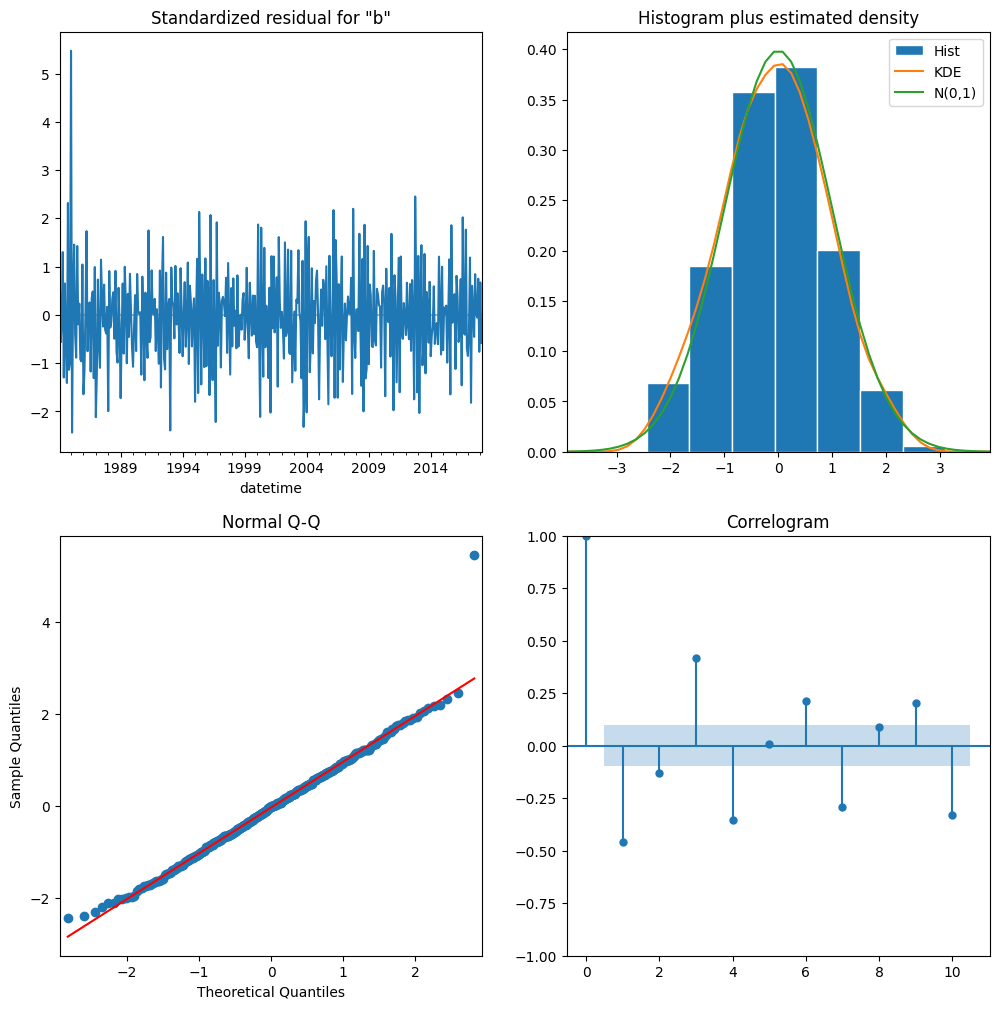

In [424]:
y = train_df[MEAT_TYPE[0]]
y

p, q, P, D, Q, method = (0, 0, 2, 1, 1, 'powell')
# (0, 0, 2, 1, 1, 'powell') # Best for 6 months pre-covid
# (2, 2, 2, 1, 2, 'lbfgs') # Best for predicting after covid
d = 1
s = 12

model = SARIMAX(y,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
model_fit = model.fit(method=method)
print(model_fit.plot_diagnostics(figsize=(12, 12)))

Save model as a pickle file

In [425]:
PATH = '../model/sarimax_meat_forecasting.pkl'
with open(PATH, 'wb') as pkl:
    pickle.dump(model_fit, pkl)

Predict and visualize

In [426]:
months_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)
forecast = model_fit.get_forecast(steps=months_gap + 6)
predict_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()
print(f'predict_mean: {predict_mean}, train_df: {train_df[MEAT_TYPE[0]]}')

predict_mean: 2018-04-01    2.040907e+09
2018-05-01    2.216157e+09
2018-06-01    2.276817e+09
2018-07-01    2.213338e+09
2018-08-01    2.337077e+09
2018-09-01    2.190123e+09
Freq: MS, Name: predicted_mean, dtype: float64, train_df: datetime
1983-01-01    1.837000e+09
1983-02-01    1.632000e+09
1983-03-01    1.808000e+09
1983-04-01    1.650000e+09
1983-05-01    1.783000e+09
                  ...     
2017-11-01    2.265800e+09
2017-12-01    2.123000e+09
2018-01-01    2.248400e+09
2018-02-01    1.956400e+09
2018-03-01    2.174700e+09
Freq: MS, Name: beef, Length: 423, dtype: float64


In [427]:
plt.figure(figsize=(12, 6))
filtered_df = train_df[str(LEARN_TO_YEAR):]
forecast_aligned = predict_mean.loc[test_df.index]
plt.plot(filtered_df.index, filtered_df[MEAT_TYPE[0]], label='Train')
plt.plot(test_df.index, test_df[MEAT_TYPE[0]], label='Test')
plt.plot(test_df.index, forecast_aligned, label='Forecast')
plt.title(f'{MEAT_TYPE[0].capitalize()} Forecasting')
plt.ylabel('Beef Production (lbs)')
plt.xlabel('Year-Month')
plt.legend()
plt.show()
forecast_aligned

KeyError: "[Timestamp('2018-10-01 00:00:00'), Timestamp('2018-11-01 00:00:00')] not in index"

<Figure size 1200x600 with 0 Axes>

Calculate MAE

In [ ]:
mae = np.abs(test_df[MEAT_TYPE[0]] - forecast_aligned).mean()
mae

65561530.61623883

Grid search

In [ ]:
# def grid_search(endog, test_endog, d=2, depth=1):
#     y = endog
#     param_grid = {
#         'ord_p': range(0, depth),
#         'ord_q': range(0, depth),
#         'season_p': range(0, depth),
#         'season_d': range(0, depth),
#         'season_q': range(0, depth),
#         'opt': ['lbfgs', 'nm', 'powell']
#     }
#     parameter_combinations = list(product(*param_grid.values()))
#     best_params = None
#     best_mae = float('inf')
#     for param in parameter_combinations:
#         try:
#             model = SARIMAX(y,
#                             order=(param[0], d, param[1]),
#                             seasonal_order=(param[2], param[3], param[4], s),
#                             enforce_stationarity=True,
#                             enforce_invertibility=True)
#             model_fit = model.fit(disp=0, method=param[5])
#             months_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)
#             forecast = model_fit.get_forecast(steps=months_gap + 6)
#             predict_mean = forecast.predicted_mean
#             forecast_aligned = predict_mean.loc[test_df.index]
#             cur_mae = np.abs(test_endog - forecast_aligned).mean()
#         except:
#             print(f"Error with params {param}")

#         if cur_mae < best_mae:
#             best_mae = cur_mae
#             best_params = param
#             print(f'Best MAE: {best_mae}, best params: {best_params} so far')

#     return (best_params, best_mae)

# best_param, best_mae = grid_search(endog=train_df[MEAT_TYPE[0]],
#                                    test_endog=test_df[MEAT_TYPE[0]],
#                                    d=1,
#                                    depth=3)
# print(best_param, best_mae)